<a href="https://colab.research.google.com/github/shailavij/VQA/blob/master/VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import Libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import spacy
import scipy.io
import gc
from sklearn.preprocessing import LabelEncoder
import pickle

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras import Input
from keras.layers.recurrent import LSTM
from keras.layers import concatenate
from keras.layers.merge import Concatenate
from keras.models import model_from_json, Model
from keras.utils import plot_model
from collections import defaultdict
import operator
from keras.utils import np_utils, generic_utils
from progressbar import Bar, ETA, Percentage, ProgressBar
from itertools import zip_longest
from keras.models import load_model
import matplotlib.pyplot as plt

In [0]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My Drive/DL_DATASet/VQA/Preprocessed Data/


/content/drive/My Drive/DL_DATASet/VQA/Preprocessed Data


In [0]:
# Reading Text file that contain Extracted Question & annotations
question= open('ques.txt','rb').read().decode('utf-8').splitlines()
questions_len = open('ques_len.txt', 'rb').read().decode('utf-8').splitlines()
answers = open('answer.txt','rb').read().decode('utf-8').splitlines()
image_id = open('images_id.txt','rb').read().decode('utf-8').splitlines()
vgg_path = "vgg_feats.mat"

In [0]:
print(question[10])
print(questions_len[10])
print(answers[10])
print(image_id[10])


Is there a bicycle in this picture?
8
yes
56205


We can take any index and its corresponding question, answer and image id. Just Visit http://cocodataset.org/#explore and type image id. You will get the image. So by this way you can check questions about images ans its answers

In [0]:
pip install spacy

In [0]:
import en_core_web_sm
nlp = en_core_web_sm.load()


# Weights and layers of the model are stored in Mat file format for VGG model.
It can be used in python via scipy library, to extract features of VGG model trainied in COOCO image dataset


In [0]:
vgg = scipy.io.loadmat(vgg_path)
features = vgg['feats']
features[10]

array([-0.       , -0.       , -0.       , ...,  0.7211761, -0.       ,
       -0.       ], dtype=float32)

Since we are creating a predictive model, we would not like to have all the words present in our vocabulary but the words which are more likely to occur or which are common. Hence we define upper limit as 1000 that is first 1000 most occuring words in vocabulary.

In [0]:
def freq_answers(questions, answers, image_id, upper_lim):
    freq_ans = defaultdict(int)
    for ans in answers:
        freq_ans[ans] +=1
    
    sort = sorted(freq_ans.items(), key=operator.itemgetter(1), reverse=True)[0:upper_lim]
    #print(sort)
    top_ans, top_freq = zip(*sort)
    #print(top_ans, top_freq)
    new_answers_train = list()
    new_questions_train = list()
    new_images_train = list()
    for ans, ques, img in zip(answers, questions, image_id):
        if ans in top_ans:
            new_answers_train.append(ans)
            new_questions_train.append(ques)
            new_images_train.append(img)
    return (new_questions_train, new_answers_train, new_images_train)

In [0]:
upper_lim = 1000
question, answers, image_id = freq_answers(question, answers, image_id, upper_lim)
questions_len, questions, answers, image_id = (list(t) for t in zip(*sorted(zip(questions_len, question, answers, image_id))))
print (len(question), len(answers),len(image_id))


105175 105175 105175


In [0]:
le = LabelEncoder()
le.fit(answers)
pickle.dump(le, open('label_encoder_lstm.pkl','wb'))

In [0]:
#Define Model Parameters
batch_size               =      512
img_dim                  =     4096
word2vec_dim             =      96
num_hidden_nodes_mlp     =     1024
num_hidden_nodes_lstm    =      512
num_layers_lstm          =        3
dropout                  =       0.5
activation_mlp           =     'tanh'
num_epochs = 5

In [0]:
img_ids = open('coco_vgg_IDMap.txt','rb').read().decode('utf-8').splitlines()
id_map = dict()
for ids in img_ids:
    id_split = ids.split()
    id_map[id_split[0]] = int(id_split[1])
    #print(id_map)

In [0]:
# Define Netwrok Architecture
# Image _model
image_model = Sequential()
image_model.add(Reshape(input_shape = (4096,), target_shape=(4096,)))
model1 = Model(inputs = image_model.input, outputs = image_model.output)
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1_input (InputLayer) (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4096)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Text_model
language_model = Sequential()
language_model.add(LSTM(output_dim=num_hidden_nodes_lstm, 
                        return_sequences=True, input_shape=(None, word2vec_dim)))

for i in range(num_layers_lstm-2):
    language_model.add(LSTM(output_dim=num_hidden_nodes_lstm, return_sequences=True))
language_model.add(LSTM(output_dim=num_hidden_nodes_lstm, return_sequences=False))

model2 = Model(language_model.input, language_model.output)
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1_input (InputLayer)    (None, None, 96)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 512)         1247232   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 512)         2099200   
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
Total params: 5,445,632
Trainable params: 5,445,632
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Keras_functional_API

combined = concatenate([image_model.output, language_model.output])

In [0]:
model = Dense(num_hidden_nodes_mlp, init='uniform', activation = 'tanh')(combined)
#model = Activation('tanh')(model)
model = Dropout(0.5)(model)

model = Dense(num_hidden_nodes_mlp, init='uniform', activation = 'tanh')(model)
#model = Activation('tanh')(model)
model = Dropout(0.5)(model)

model = Dense(num_hidden_nodes_mlp, init='uniform', activation = 'tanh')(model)
#model = Activation('tanh')(model)
model = Dropout(0.5)(model)

model = Dense(upper_lim)(model)
model = Activation("softmax")(model)

model = Model(inputs=[image_model.input, language_model.input], outputs=model)

In [0]:
# COmpile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_1_input (InputLayer)       (None, None, 96)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 512)    1247232     lstm_1_input[0][0]               
__________________________________________________________________________________________________
reshape_1_input (InputLayer)    (None, 4096)         0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 512)    2099200     lstm_1[0][0]                     
____________________________________________________________________________________________

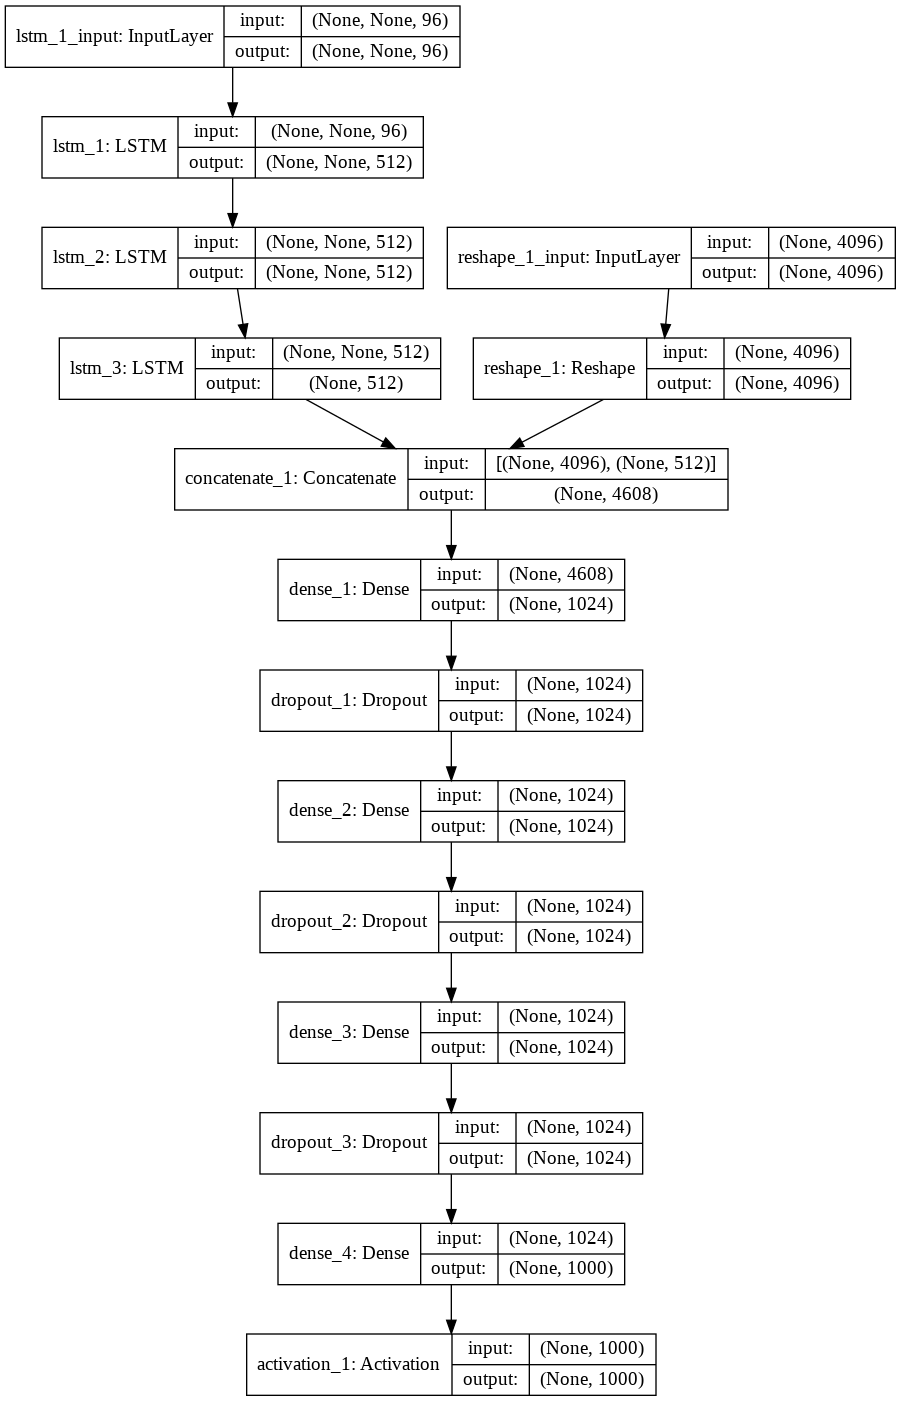

In [0]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
def get_questions_tensor_timeseries(questions, nlp, timesteps):
    assert not isinstance(questions, list)
    nb_samples = len(questions)
    word_vec_dim = nlp(questions[0])[0].vector.shape[0]
    questions_tensor = np.zeros((nb_samples, timesteps, word_vec_dim))
    for i in range(len(questions)):
        tokens = nlp(questions[i])
        for j in range(len(tokens)):
            if j<timesteps:
                questions_tensor[i,j,:] = tokens[j].vector
    return questions_tensor

def get_images_matrix(img_coco_ids, img_map, VGGfeatures):
    assert not isinstance(img_coco_ids, list)
    nb_samples = len(img_coco_ids)
    nb_dimensions = VGGfeatures.shape[0]
    image_matrix = np.zeros((nb_samples, nb_dimensions))
    for j in range(len(img_coco_ids)):
        image_matrix[j,:] = VGGfeatures[:,img_map[img_coco_ids[j]]]

    return image_matrix

def get_answers_sum(answers, encoder):
    assert not isinstance(answers, list)
    y = encoder.transform(answers)
    nb_classes = encoder.classes_.shape[0]
    Y = np_utils.to_categorical(y, nb_classes)
    return Y

def grouped(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
   #print(args)
    #for a in(zip_longest(*args, fillvalue=fillvalue)):
        #print(a)
    return zip_longest(*args, fillvalue=fillvalue)


In [0]:
# Train_test Split

train_questions = questions[:95000]
train_answers = answers[:95000]
train_image_id = image_id[:95000]

test_questions = questions[95000:]
test_answers = answers[95000:]
test_image_id = image_id[95000:]

In [0]:
print("Total no.of QA in Trainset ",len(train_questions))
print("Total no.of QA in Testset ",len(test_questions))
print("Total no.of Answer in Trainset ",len(train_answers))
print("Total no.of image_ID in Trainset ",len(train_image_id))

Total no.of QA in Trainset  95000
Total no.of QA in Testset  10175
Total no.of Answer in Trainset  95000
Total no.of image_ID in Trainset  95000


In [0]:
# Train the model
for k in range(num_epochs):
    print("Epoch Number: ",k+1)
    progbar = generic_utils.Progbar(len(train_questions))
    for question_batch, ans_batch, im_batch in zip(grouped(train_questions, batch_size, fillvalue=train_questions[-1]), 
                                               grouped(train_answers, batch_size, fillvalue=train_answers[-1]),
                                               grouped(train_image_id, batch_size, fillvalue=train_image_id[-1])):
        timestep = len(nlp(question_batch[-1]))
        X_ques_batch = get_questions_tensor_timeseries(question_batch, nlp, timestep)
        X_img_batch = get_images_matrix(im_batch, id_map, features)
        Y_batch = get_answers_sum(ans_batch, le)
        print(X_ques_batch.shape)
        loss = model.train_on_batch(({'lstm_1_input' : X_ques_batch, 'reshape_1_input' : X_img_batch}), Y_batch)
        progbar.add(batch_size, values=[('train loss', loss)])

Epoch Number:  1
(512, 9, 96)
95232/95000 [==============================] - 1317s 14ms/step - train loss: 4.7075
Epoch Number:  2
(512, 9, 96)
95232/95000 [==============================] - 1276s 13ms/step - train loss: 3.9135
Epoch Number:  3
(512, 9, 96)
95232/95000 [==============================] - 1253s 13ms/step - train loss: 3.6603
Epoch Number:  4
(512, 9, 96)
95232/95000 [==============================] - 1254s 13ms/step - train loss: 3.4764
Epoch Number:  5
(512, 9, 96)
95232/95000 [==============================] - 1263s 13ms/step - train loss: 3.2786


In [0]:
label_encoder = pickle.load(open('label_encoder_lstm.pkl','rb'))

In [0]:
y_pred = []
batch_size = 512 

#print ("Word2Vec Loaded!") 

widgets = ['Evaluating ', Percentage(), ' ', Bar(marker='#',left='[',right=']'), ' ', ETA()]
pbar = ProgressBar(widgets=widgets)

In [0]:
for qu_batch,an_batch,im_batch in pbar(zip(grouped(test_questions, batch_size, 
                                                   fillvalue=test_questions[0]), 
                                           grouped(test_answers, batch_size, 
                                                   fillvalue=test_answers[0]), 
                                           grouped(test_image_id, batch_size, 
                                                   fillvalue=test_image_id[0]))):
    timesteps = len(nlp(qu_batch[-1]))
    X_ques_batch = get_questions_tensor_timeseries(qu_batch, nlp, timesteps)
    X_i_batch = get_images_matrix(im_batch, id_map, features)
    #X_batch = [X_ques_batch, X_i_batch]
    y_predict = model.predict(({'lstm_1_input' : X_ques_batch, 'reshape_1_input' : X_img_batch}))
    y_predict = np.argmax(y_predict,axis=1)
    y_pred.extend(label_encoder.inverse_transform(y_predict))

Evaluating N/A% [#                                             ] Time:  0:01:38


In [0]:

correct_val = 0.0
total = 0


for pred, truth, ques, img in zip(y_pred, test_answers, test_questions, test_image_id):
    t_count = 0
    for _truth in truth.split(';'):
        if pred == truth:
            t_count += 1 
    if t_count >=1:
        correct_val +=1
    else:
        correct_val += float(t_count)/3

    total +=1

In [0]:
print ("Accuracy: ", round((correct_val/total)*100,2))

Accuracy:  20.37


In [0]:
model.save("/content/drive/My Drive/DL_DATASet/VQA/model.h5")